In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [2]:
MODEL_PATH='./data/transformer-fasttext-big-subword-longtrain.ckpt'

In [3]:
#import mutual information library from microsoft nlp recipe
from interpreter.Interpreter import Interpreter

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext.vocab import FastText
import itertools
from fasttext import load_model
from torch.autograd import Variable
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import matplotlib.pyplot as plt

# FastTextにInterpreter使うと何が嬉しいの?

* そもそもBertにCNNで回帰したらクソみたいな結果出ちゃった
* CharLM回してみたら学習できねえ（NLPむずい）
* 

# No Bag

In [4]:

# taken from https://github.com/facebookresearch/fastText/blob/master/python/doc/examples/FastTextEmbeddingBag.py
class FastTextEmbedding(nn.Embedding):
    def __init__(self, model_path, itos, device):
        self.model = load_model(model_path)
        input_matrix = self.model.get_input_matrix()
        input_matrix_shape = input_matrix.shape
        self.itos = itos
        self.device = device
        super().__init__(input_matrix_shape[0], input_matrix_shape[1])
        self.weight.data.copy_(torch.FloatTensor(input_matrix))

    def forward(self, indices):
        #print(indices.shape)
        orig = indices.shape
        indices = indices.view(orig[0] * orig[1])

        word_subwords = np.empty([0], dtype=np.int64)
        word_subinds = np.empty([0], dtype=np.int64)
        word_offsets = [0]
        for index in indices:
            word = self.itos[index]
            subwords, subinds = self.model.get_subwords(word)
            word_subinds = np.concatenate((word_subinds, subinds))
            word_offsets.append(word_offsets[-1] + len(subinds))
        
        word_offsets = word_offsets[:-1]
        ind = torch.LongTensor(word_subinds).to(device)
        offsets = torch.LongTensor(word_offsets).to(device)

        result = self.forward_super(ind)
        result = result.view(orig[0], orig[1], -1)
        return result
    
    def forward_super(self, ind):
        return super().forward(ind)

class TransformerModel(nn.Module):
    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, device, fasttext_model_path, itos, dropout=0.5):
        super(TransformerModel, self).__init__()
        from torch.nn import TransformerEncoder, TransformerEncoderLayer
        self.model_type = 'Transformer'
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = FastTextEmbedding(fasttext_model_path, itos, device)
        self.ninp = ninp
        self.decoder = nn.Linear(ninp, ntoken)
        self.device = device

        self.init_weights()

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.encoder(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        output = self.decoder(output)
        return output

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


import torchtext
from torchtext.data.utils import get_tokenizer
TEXT = torchtext.data.Field(tokenize=get_tokenizer("basic_english"),
                            init_token='<sos>',
                            eos_token='<eos>',
                            lower=True)
train_txt, val_txt, test_txt = torchtext.datasets.WikiText2.splits(TEXT)
TEXT.build_vocab(train_txt)

def batchify(data, bsz):
    data = TEXT.numericalize([data.examples[0].text])
    # Divide the dataset into bsz parts.
    nbatch = data.size(0) // bsz
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * bsz)
    # Evenly divide the data across the bsz batches.
    data = data.view(bsz, -1).t().contiguous()
    return data.to(device)

batch_size = 20
eval_batch_size = 10
train_data = batchify(train_txt, batch_size)
val_data = batchify(val_txt, eval_batch_size)
test_data = batchify(test_txt, eval_batch_size)

bptt = 35
def get_batch(source, i):
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].view(-1)
    return data, target

ntokens = len(TEXT.vocab.stoi) # the size of vocabulary
emsize = 100 # embedding dimension
nhid = 200 # the dimension of the feedforward network model in nn.TransformerEncoder
#nlayers = 2 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nlayers = 4 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
#nhead = 2 # the number of heads in the multiheadattention models
nhead = 4 # the number of heads in the multiheadattention models
dropout = 0.2 # the dropout value
#dropout = 0.4 # the dropout value
model = TransformerModel(ntokens, emsize, nhead, nhid, nlayers, device,
        fasttext_model_path="/home/ubuntu/fil9.bin", itos=TEXT.vocab.itos, dropout=dropout).to(device)
checkpoint = torch.load(MODEL_PATH)
model.load_state_dict(checkpoint)
model.eval().to(device)

TransformerModel(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): Linear(in_features=100, out_features=100, bias=True)
        )
        (linear1): Linear(in_features=100, out_features=200, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=200, out_features=100, bias=True)
        (norm1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): Linear(in_features=100, out_features=100, bias=True)
        )
        (linear1): Linear(in_features=100, out_features=20

In [5]:
def bagging_result(result, offsets):
    res_np = result.detach().cpu().numpy()
    off_np = offsets.detach().cpu().numpy()

    splitted = np.split(res_np, off_np)[1:]
    return torch.FloatTensor([np.mean(arr, axis=0) for arr in splitted]).to(device)

# Test

In [6]:
encoder = model.encoder
# encoder_bag = model_bag.encoder

In [7]:
def calculate_x(src, device):
    device = src.device
    mask = model._generate_square_subsequent_mask(len(src)).to(device)
    model.src_mask = mask

    orig = src.shape
    indices = src.view(orig[0] * orig[1])

    ind_to_subwords_dict = {}
    word_subinds = np.empty([0], dtype=np.int64)
    word_offsets = [0]

    for index in indices:
        word = encoder.itos[index]
        subwords, subinds = encoder.model.get_subwords(word)
        ind_to_subwords_dict.update(dict(zip(subinds, subwords)))
        word_subinds = np.concatenate((word_subinds, subinds))
        word_offsets.append(word_offsets[-1] + len(subinds))

    word_offsets = word_offsets[:-1]
    inds = torch.LongTensor(word_subinds).to(device)
    offsets = torch.LongTensor(word_offsets).to(device)

    x_fasttext = encoder.forward_super(inds)
    subwords = list(map(lambda ind: ind_to_subwords_dict[ind.item()], inds))
    
    return x_fasttext, subwords, orig, offsets

def generate_FT_phi(model, orig, offsets, layer):
    def Phi(x):
        result = bagging_result(x, offsets)
        result = result.view(orig[0], orig[1], -1)

        result *= math.sqrt(model.ninp)
        result = model.pos_encoder(result)
        output = model.transformer_encoder(result, model.src_mask)
       
        hidden_states = output 
        model_list = model.transformer_encoder.layers[:layer]
        for layer_module in model_list:
            hidden_states = layer_module(hidden_states, model.src_mask)
        return hidden_states.view(-1, 100)

    return Phi

def calculate_regularization(sampled_x, Phi, reduced_axes=None, device=None):
    """ Calculate the variance that is used for Interpreter

    Args:
        sampled_x (list of torch.FloatTensor):
            A list of sampled input embeddings $x$, each $x$ is of shape
            ``[length, dimension]``. All the $x$s can have different length,
            but should have the same dimension. Sampled number should be
            higher to get a good estimation.
        reduced_axes (list of ints, Optional):
            The axes that is variable in Phi (e.g., the sentence length axis).
            We will reduce these axes by mean along them.

    Returns:
        torch.FloatTensor: The regularization term calculated

    """
    sample_s = Phi(sampled_x)
    return torch.std(sample_s, axis=0)


In [16]:
# reguralization
reg_data = TEXT.numericalize([train_txt.examples[0].text[:5000]]).to(device)

sampled_x, sampled_subwords, sampled_orig, sampled_offsets = calculate_x(reg_data, device)
model.src_mask = model.src_mask.to(device)
sampled_phi = generate_FT_phi(model, sampled_orig, sampled_offsets, 4)

regularization = calculate_regularization(sampled_x, sampled_phi, device=device)

# Test

## I am running down the road .

In [96]:
text = ["i", "am", "running", "down", "the", "road", ".", "<eos>"]

src = TEXT.numericalize([text]).to(device)

x, subwords, orig, offsets = calculate_x(src, device)
phi = generate_FT_phi(model, orig, offsets, 4)

In [97]:
interpreter = Interpreter(
    x=x,
    Phi=phi,
    regularization=regularization,
    scale=10 * 0.1,
    words=subwords,
)
interpreter.to(device)

interpreter.optimize(iteration=1000, lr=0.01, show_progress=True)

100%|██████████| 1000/1000 [00:43<00:00, 22.87it/s]


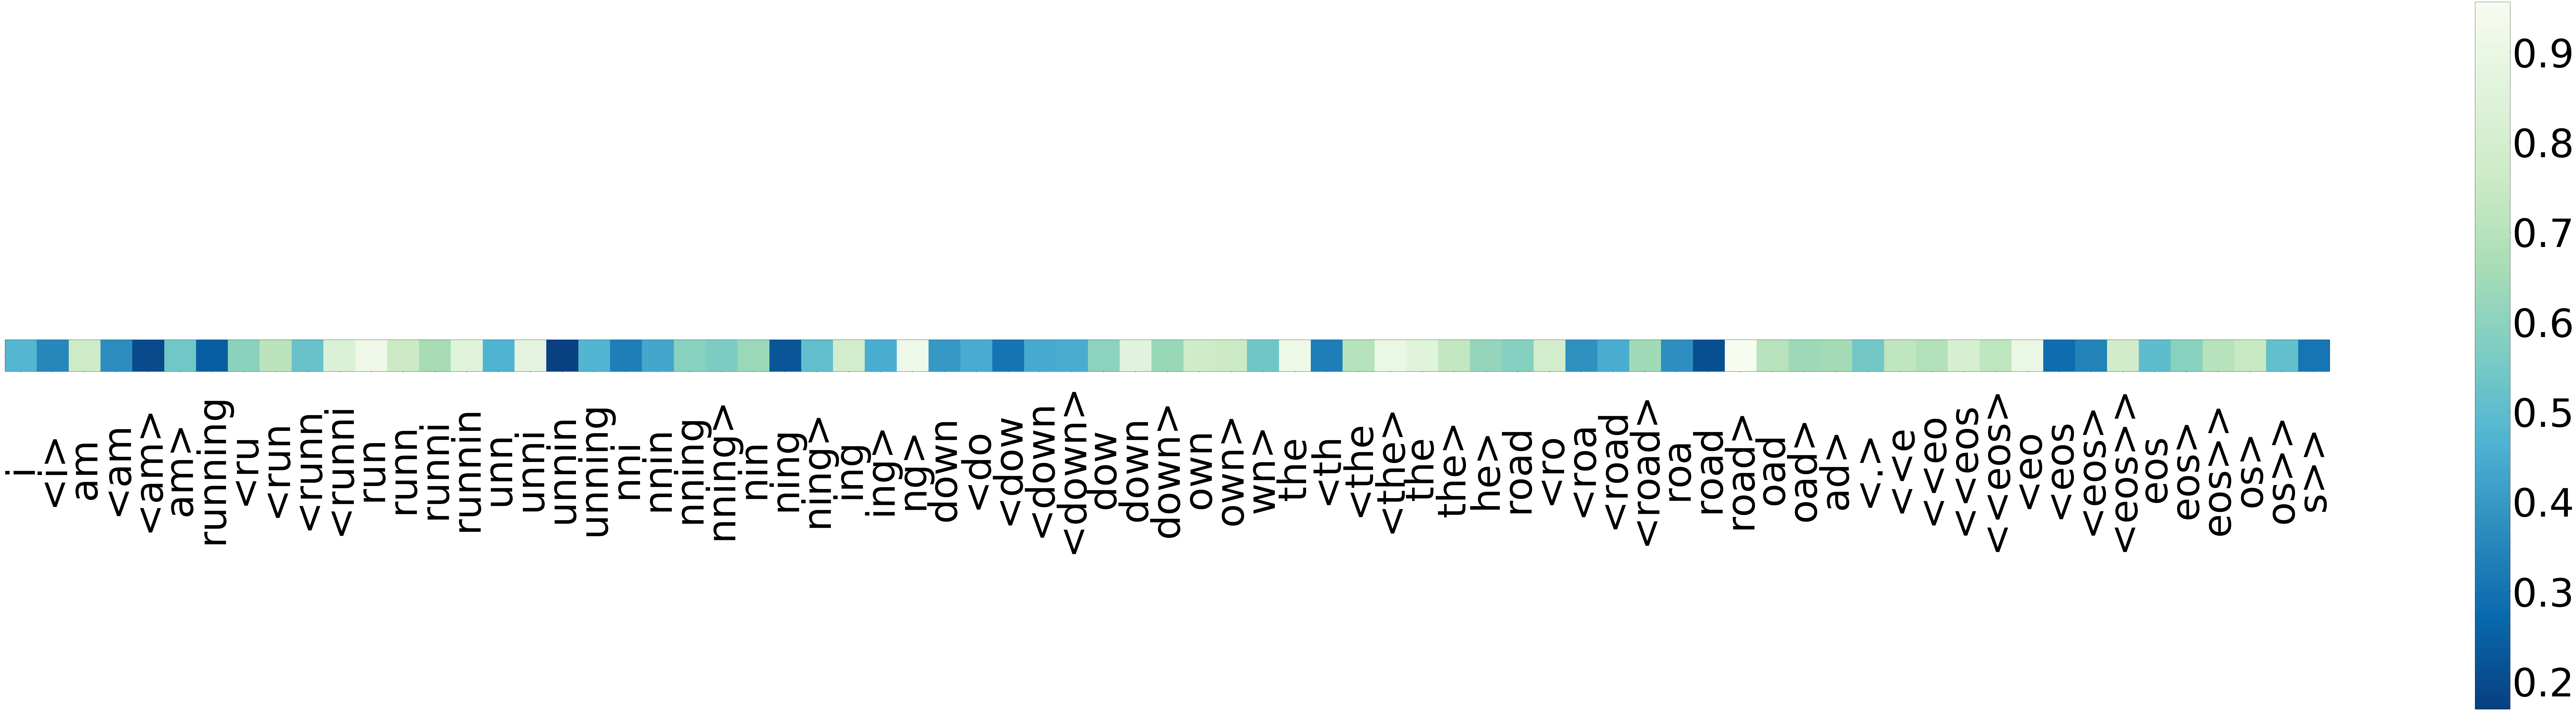

In [98]:
sigma_ = interpreter.get_sigma()
_, ax = plt.subplots(figsize=(200, 50))
im = ax.imshow([sigma_], cmap="GnBu_r")
ax.set_xticks(range(interpreter.s))
ax.set_xticklabels(interpreter.words, rotation = 90, va="center", fontdict={'fontsize':150}, position=(0, -3.0))
ax.set_yticks([0])
ax.set_yticklabels([""])
cb = plt.colorbar(im, orientation="vertical")
cb.ax.tick_params(labelsize=150)
plt.show()

In [99]:
min_sigmas = np.argsort(sigma_)[:5]
np.array(interpreter.words)[min_sigmas]

array(['unnin', '<am>', 'road', 'ning', 'running'], dtype='<U7')

## The choice of example sentence wasn't wise.

In [100]:
text = "the choice of example sentence wasn ' t wise . <eos>".split()

src = TEXT.numericalize([text]).to(device)

x, subwords, orig, offsets = calculate_x(src, device)
phi = generate_FT_phi(model, orig, offsets, 4)

In [101]:
interpreter = Interpreter(
    x=x,
    Phi=phi,
    regularization=regularization,
    scale=10 * 0.1,
    words=subwords,
)
interpreter.to(device)

interpreter.optimize(iteration=1000, lr=0.01, show_progress=True)

100%|██████████| 1000/1000 [00:43<00:00, 23.11it/s]


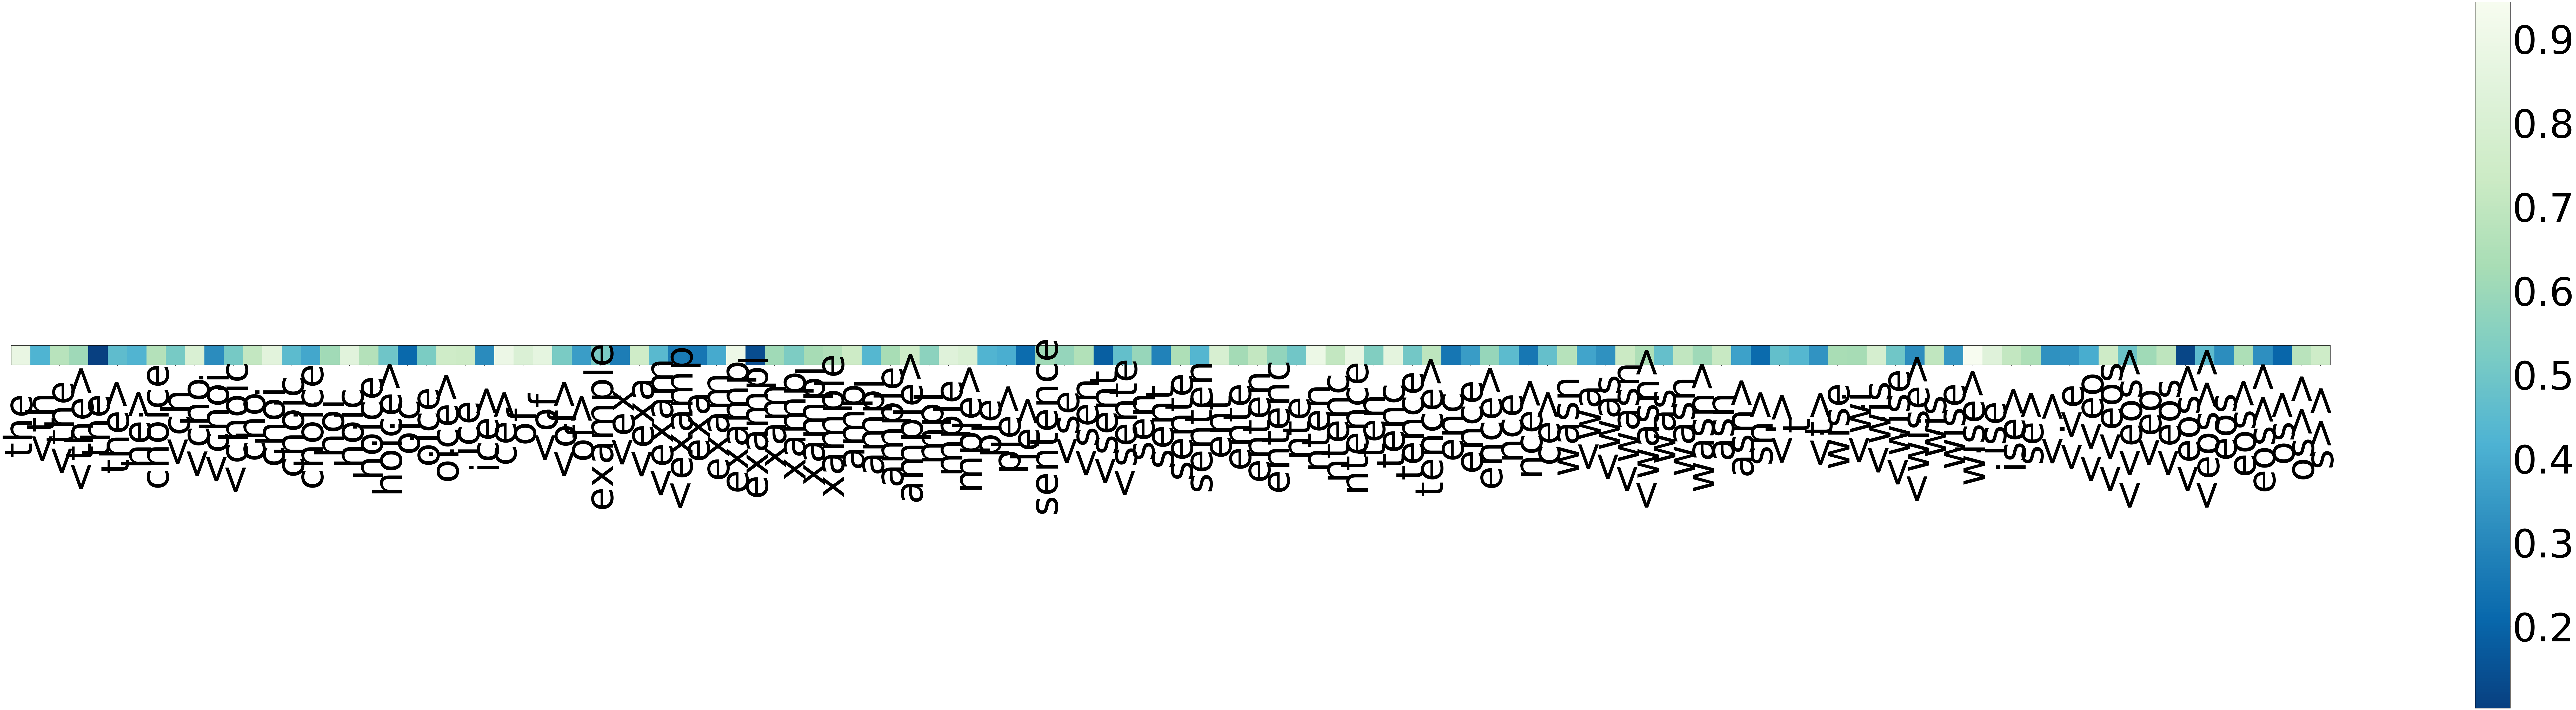

In [102]:
sigma_ = interpreter.get_sigma()
_, ax = plt.subplots(figsize=(200, 50))
im = ax.imshow([sigma_], cmap="GnBu_r")
ax.set_xticks(range(interpreter.s))
ax.set_xticklabels(interpreter.words, rotation = 90, va="center", fontdict={'fontsize':150}, position=(0, -3.0))
ax.set_yticks([0])
ax.set_yticklabels([""])
cb = plt.colorbar(im, orientation="vertical")
cb.ax.tick_params(labelsize=150)
plt.show()

In [103]:
min_sigmas = np.argsort(sigma_)[:5]
np.array(interpreter.words)[min_sigmas]

array(['the', '<eos>', 'exampl', '<sent', 'os>'], dtype='<U8')

## He is swimmin in the river

In [104]:
text = "he is swimming in the river . <eos>".split()

src = TEXT.numericalize([text]).to(device)

x, subwords, orig, offsets = calculate_x(src, device)
phi = generate_FT_phi(model, orig, offsets, 4)

In [105]:
interpreter = Interpreter(
    x=x,
    Phi=phi,
    regularization=regularization,
    scale=10 * 0.1,
    words=subwords,
)
interpreter.to(device)

interpreter.optimize(iteration=5000, lr=0.01, show_progress=True)

100%|██████████| 5000/5000 [03:37<00:00, 23.04it/s]


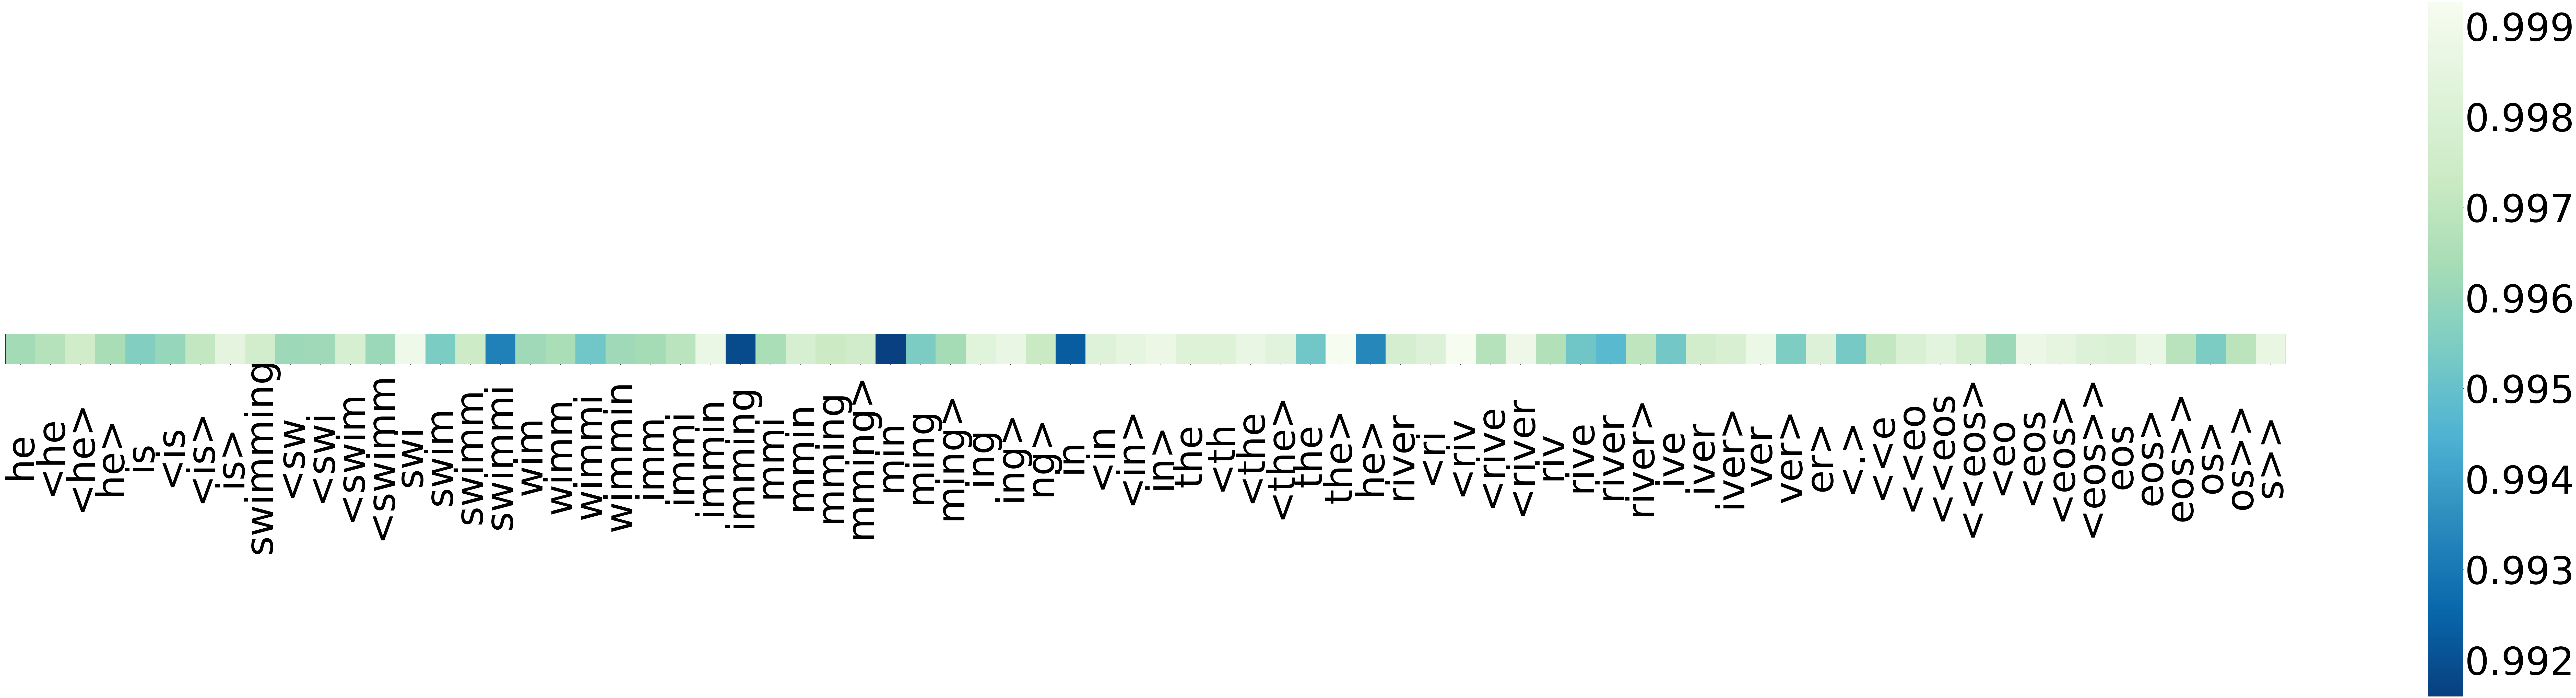

In [106]:
sigma_ = interpreter.get_sigma()
_, ax = plt.subplots(figsize=(200, 50))
im = ax.imshow([sigma_], cmap="GnBu_r")
ax.set_xticks(range(interpreter.s))
ax.set_xticklabels(interpreter.words, rotation = 90, va="center", fontdict={'fontsize':150}, position=(0, -3.0))
ax.set_yticks([0])
ax.set_yticklabels([""])
cb = plt.colorbar(im, orientation="vertical")
cb.ax.tick_params(labelsize=150)
plt.show()

In [107]:
min_sigmas = np.argsort(sigma_)[:5]
np.array(interpreter.words)[min_sigmas]

array(['min', 'imming', 'in', 'swimmi', 'he>'], dtype='<U8')